# AutoML with Image data  - Hyperparameter Optimization


In the previous tutorial on using AutoGluon for image data, we saw that deep learning involves tons of design decisions (we call these *hyperparameters*) that affect the performance of the resulting model. Some common hyperparameters include choices around:

- [**Network Architecture**](http://d2l.ai/chapter_convolutional-modern/index.html): how many layers should our network have, how many weights in each fully-connected layer, how many filters in each convolutional layer and what size should each one be, should residual connections be employed, what activation function, etc. 

- **Optimizing network parameters**: [which optimization algorithm to use](https://ruder.io/optimizing-gradient-descent/), [what learning rate to use](http://d2l.ai/chapter_optimization/lr-scheduler.html), [how to set a dynamic learning rate schedule](http://d2l.ai/chapter_optimization/lr-scheduler.html), etc.

- **Regularization**: To what degree should we use the following: [dropout](http://d2l.ai/chapter_multilayer-perceptrons/dropout.html?highlight=dropout), [weight decay](http://d2l.ai/chapter_multilayer-perceptrons/weight-decay.html?highlight=weight%20decay), [batch normalization](http://d2l.ai/chapter_convolutional-modern/batch-norm.html?highlight=batch%20normalization), etc.

- **Transfer Learning**: Should we initialize our network from a [pretrained model](http://d2l.ai/chapter_computer-vision/fine-tuning.html) and if so [which one](https://gluon-cv.mxnet.io/model_zoo/classification.html)?

- **Data Augmentation**: Should we augment our training data with synthetically-generated examples and if so using which [augmentation technique](http://d2l.ai/chapter_computer-vision/image-augmentation.html)?




Unlike simpler models used for tabular data for which reasonable default hyperparameters exist, the complex neural networks used for image (and text) data will be limited to suboptimal accuracy unless their hyperparameters are appropriately chosen. Because it's usually unclear what hyperparameter choices will be good for a particular dataset, 
deep learning has sometimes been referred to as [*dark magic*](https://medium.com/@alitech_2017/revealing-the-dark-magic-behind-deep-learning-eae1b451354d) or [*alchemy*](https://www.youtube.com/watch?v=x7psGHgatGM).

To address this issue, AutoGluon trains many networks with different hyperparameter choices for each. Instead of having to know what specific hyperparameter-values to use, you can instead specify a search space of many hyperparameters to consider, and also specify *how* to search through this hyperparameter space for the best configuration. 
If these are properly specified, you may be able to achieve superior accuracy within less training time, but even using AutoGluon's default hyperparameter search-space/search-strategy should allow you to achieve reasonable accuracy if you let `fit()` run long enough (with many trials).


Here we'll work with same image classification data as before. Recall that `fit()` will automatically partition the provided data into disjoint training/validation sets.

In [1]:
import autogluon as ag
from autogluon import ImageClassification as task
import gluoncv

filename = ag.download('https://autogluon.s3.amazonaws.com/datasets/shopee-iet.zip')
ag.unzip(filename)

dataset = task.Dataset('data/train')

## Specify which Pretrained Networks to consider

Instead of relying on the default options, we can specify which pretrained neural network candidates AutoGluon should consider during `fit()`. 
Given such a list, AutoGluon will try training different networks from this list to identify the best-performing candidate. 
This is an example of an `autogluon.space.Categorical` search space, in which there are a limited number of values to choose from. In our example below, the options are: [ResNet18 or MobileNetV2](https://gluon-cv.mxnet.io/model_zoo/classification.html), where AutoGluon also will search over three values (0.25, 0.5, 1.0) of the latter network's own [`multiplier`](https://gluon-cv.mxnet.io/_modules/gluoncv/model_zoo/mobilenet.html#MobileNetV2) hyperparameter (which controls this network's width).

In [2]:
@ag.func(
    multiplier=ag.Categorical(0.25, 0.5, 1.0),
)
def get_mobilenet(multiplier):
    return gluoncv.model_zoo.MobileNetV2(multiplier=multiplier, classes=4)

net = ag.space.Categorical('resnet18_v1b', get_mobilenet())
print(net)

Categorical['resnet18_v1b', AutoGluonObject]


## Specify Optimizer Hyperparameters to consider

Similarly, we can construct another search-space to identify what optimization hyperparameters work best for our task. Here we demonstrate this for the [Nesterov Accelerated SGD](https://arxiv.org/pdf/1607.01981.pdf) optimizer, specifying `autogluon.space.Real` spaces that instruct AutoGluon to search within continuous-valued ranges (optionally on a log-scale). Note that you can use analogous AutoGluon code to search the hyperparameters (here, constructor-arguments) of *any* Python object that gets passed into the training function.

In [3]:
from mxnet import optimizer as optim

@ag.obj(
    learning_rate=ag.space.Real(1e-4, 1e-2, log=True),
    momentum=ag.space.Real(0.85, 0.95),
    wd=ag.space.Real(1e-6, 1e-2, log=True)
)
class NAG(optim.NAG):
    pass

optimizer = NAG()
print(optimizer)

AutoGluonObject -- NAG


## Search Algorithms
 
Beyond specifying the space of hyperparameter configurations to consider, you can also tell AutoGluon what strategy it should employ to actually search through this space ([`autogluon.searcher`](https://autogluon.mxnet.io/api/autogluon.searcher.html)). AutoGluon supports various [search strategies](https://autogluon.mxnet.io/api/autogluon.searcher.html) to seek out the best hyperparameter values. 
This process of finding good hyperparameters from a given search space is commonly referred to as *hyperparameter optimization* (HPO) or *hyperparameter tuning*. 
After the searcher has specified which hyperparameter configurations to try next, 
AutoGluon relies on a scheduler to actually launch & orchestrate training jobs under these hyperparameter-settings ([`autogluon.scheduler`](https://autogluon.mxnet.io/api/autogluon.scheduler.html)).

<img src="files/images/autogluon_system.png" width="500" height="400">

- **Searcher**: suggests promising hyperparameter configurations for the next training jobs.
- **Scheduler**: launches the training jobs once computation resources become available and monitors training progress.

The basic first-in first-out (FIFO) scheduler simply runs training jobs in the order that hyperparameter-configurations are suggested by the searcher ([`autogluon.scheduler.FIFOScheduler`](https://autogluon.mxnet.io/api/autogluon.scheduler.html#autogluon.scheduler.FIFOScheduler)). If one training job does not require all of the available compute resources, the scheduler may launch others in parallel while sufficient compute resources remain available. A straightforward HPO approach combines this FIFO scheduler with a searcher that just randomly samples hyperparameter-configurations to try next ([`autogluon.searcher.RandomSearcher`](https://autogluon.mxnet.io/api/autogluon.searcher.html#autogluon.searcher.RandomSearcher)). While it seems naive, random search can be [suprisingly competitive in practice](https://www.argmin.net/2016/06/20/hypertuning/), and is [usually better than grid search for optimizing many hyperparameters](http://www.jmlr.org/papers/volume13/bergstra12a/bergstra12a.pdf).


### Bayesian Optimization

From the previously-tried (hyperparameter-configuration, validation-performance) observations, [Bayesian Optimization](https://distill.pub/2020/bayesian-optimization/) fits a probabilistic *surrogate model* to estimate the underlying function that relates each hyperparameter configuration to the resulting validation performance of a model trained under this hyperparameter configuration ([Agnihotri et al, 2020](https://distill.pub/2020/bayesian-optimization/)).  We next use these probabilistic posterior estimates to decide which hyperparameter-configuration to try in the next training job. Here we follow an *acquisition function* that controls whether we prefer to try a configuration we are confident should perform well (because we've previously observed similar configurations with good performance), or a configuration whose performance we are highly uncertain about (because we've not previously tried any remotely similar configurations). After the new training job completes, we can use the performance produced by this new hyperparameter-configuration to update our surrogate model, and then keep iterating this process.

<img src="files/images/bayesopt.png" width="500" height="400">

Below we show how to use Bayesian Optimization for the HPO search with [`autogluon.searcher.SKoptSearcher`](https://autogluon.mxnet.io/api/autogluon.searcher.html#autogluon.searcher.SKoptSearcher).  You can (optionally) specify what kind of surrogate model to use (Gaussian Process, Random Forest, etc.), as well as which acquisition function to employ (eg. [Expected Improvement, Lower Confidence Bound, etc.](https://www.cs.ox.ac.uk/people/nando.defreitas/publications/BayesOptLoop.pdf)).  Here we instruct AutoGluon to perform Bayesian optimization using a Random Forest surrogate model with acquisitions based on Expected Improvement.

scheduler_options: Key 'training_history_callback_delta_secs': Imputing default value 60
scheduler_options: Key 'delay_get_config': Imputing default value True

Starting Experiments
Num of Finished Tasks is 0
Num of Pending Tasks is 4


scheduler: FIFOScheduler(
DistributedResourceManager{
(Remote: Remote REMOTE_ID: 0, 
	<Remote: 'inproc://172.31.68.247/2447/1' processes=1 threads=4, memory=64.28 GB>, Resource: NodeResourceManager(4 CPUs, 1 GPUs))
})



{'dataset': <autogluon.task.image_classification.dataset.NativeImageFolderDataset object at 0x7f09c8c4add0>, 'net': 'resnet18_v1b', 'optimizer': <__main__.NAG object at 0x7f09c0042110>, 'loss': SoftmaxCrossEntropyLoss(batch_axis=0, w=None), 'metric': 'accuracy', 'num_gpus': 1, 'split_ratio': 0.8, 'batch_size': 64, 'input_size': 224, 'epochs': 2, 'final_fit_epochs': 2, 'verbose': True, 'num_workers': 4, 'hybridize': True, 'final_fit': False, 'tricks': Dict{'last_gamma': False, 'use_pretrained': True, 'use_se': False, 'mixup': False, 'mixup_alpha': 0.2, 'mixup_off_epoch': 0, 'label_smoothing': False, 'no_wd': False, 'teacher_name': None, 'temperature': 20.0, 'hard_weight': 0.5, 'batch_norm': False, 'use_gn': False}, 'lr_config': Dict{'lr_mode': 'cosine', 'lr_decay': 0.1, 'lr_decay_period': 0, 'lr_decay_epoch': '40,80', 'warmup_lr': 0.0, 'warmup_epochs': 0}, 'task_id': 0}


{'dataset': <autogluon.task.image_classification.dataset.NativeImageFolderDataset object at 0x7f09c00d8ed0>, 'net': MobileNetV2(
  (features): HybridSequential(
    (0): Conv2D(None -> 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
    (1): BatchNorm(axis=1, eps=1e-05, momentum=0.9, fix_gamma=False, use_global_stats=False, in_channels=None)
    (2): ReLU6(
    
    )
    (3): LinearBottleneck(
      (out): HybridSequential(
        (0): Conv2D(None -> 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
        (1): BatchNorm(axis=1, eps=1e-05, momentum=0.9, fix_gamma=False, use_global_stats=False, in_channels=None)
        (2): ReLU6(
        
        )
        (3): Conv2D(None -> 16, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (4): BatchNorm(axis=1, eps=1e-05, momentum=0.9, fix_gamma=False, use_global_stats=False, in_channels=None)
      )
    )
    (4): LinearBottleneck(
      (out): HybridSequential(
        (0): Conv2D(None -

{'dataset': <autogluon.task.image_classification.dataset.NativeImageFolderDataset object at 0x7f099c4a8790>, 'net': 'resnet18_v1b', 'optimizer': <__main__.NAG object at 0x7f099c4a3390>, 'loss': SoftmaxCrossEntropyLoss(batch_axis=0, w=None), 'metric': 'accuracy', 'num_gpus': 1, 'split_ratio': 0.8, 'batch_size': 64, 'input_size': 224, 'epochs': 2, 'final_fit_epochs': 2, 'verbose': True, 'num_workers': 4, 'hybridize': True, 'final_fit': False, 'tricks': Dict{'last_gamma': False, 'use_pretrained': True, 'use_se': False, 'mixup': False, 'mixup_alpha': 0.2, 'mixup_off_epoch': 0, 'label_smoothing': False, 'no_wd': False, 'teacher_name': None, 'temperature': 20.0, 'hard_weight': 0.5, 'batch_norm': False, 'use_gn': False}, 'lr_config': Dict{'lr_mode': 'cosine', 'lr_decay': 0.1, 'lr_decay_period': 0, 'lr_decay_epoch': '40,80', 'warmup_lr': 0.0, 'warmup_epochs': 0}, 'task_id': 2}


{'dataset': <autogluon.task.image_classification.dataset.NativeImageFolderDataset object at 0x7f099ffccd10>, 'net': MobileNetV2(
  (features): HybridSequential(
    (0): Conv2D(None -> 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
    (1): BatchNorm(axis=1, eps=1e-05, momentum=0.9, fix_gamma=False, use_global_stats=False, in_channels=None)
    (2): ReLU6(
    
    )
    (3): LinearBottleneck(
      (out): HybridSequential(
        (0): Conv2D(None -> 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
        (1): BatchNorm(axis=1, eps=1e-05, momentum=0.9, fix_gamma=False, use_global_stats=False, in_channels=None)
        (2): ReLU6(
        
        )
        (3): Conv2D(None -> 16, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (4): BatchNorm(axis=1, eps=1e-05, momentum=0.9, fix_gamma=False, use_global_stats=False, in_channels=None)
      )
    )
    (4): LinearBottleneck(
      (out): HybridSequential(
        (0): Conv2D(None -

{'dataset': <autogluon.task.image_classification.dataset.NativeImageFolderDataset object at 0x7f099c0bfe50>, 'net': 'resnet18_v1b', 'optimizer': <__main__.NAG object at 0x7f099c0bf1d0>, 'loss': SoftmaxCrossEntropyLoss(batch_axis=0, w=None), 'metric': 'accuracy', 'num_gpus': 1, 'split_ratio': 0.8, 'batch_size': 64, 'input_size': 224, 'epochs': 2, 'final_fit_epochs': 2, 'verbose': True, 'num_workers': 4, 'hybridize': True, 'final_fit': True, 'tricks': Dict{'last_gamma': False, 'use_pretrained': True, 'use_se': False, 'mixup': False, 'mixup_alpha': 0.2, 'mixup_off_epoch': 0, 'label_smoothing': False, 'no_wd': False, 'teacher_name': None, 'temperature': 20.0, 'hard_weight': 0.5, 'batch_norm': False, 'use_gn': False}, 'lr_config': Dict{'lr_mode': 'cosine', 'lr_decay': 0.1, 'lr_decay_period': 0, 'lr_decay_epoch': '40,80', 'warmup_lr': 0.0, 'warmup_epochs': 0}, 'task_id': 4}


Saving Training Curve in checkpoint/plot_training_curves.png


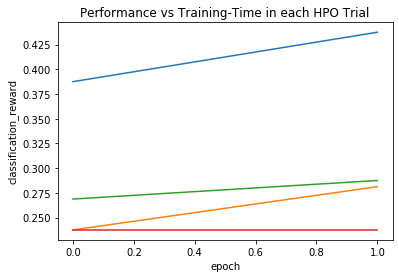

Accuracy on Validation Data: 0.438


In [4]:
num_train_epochs = 2 # How many epochs to train each network. Small value used just for quick demo, you should increase it.
num_hpo_trials = 4 # How many networks to train with different hyperparameters. Small value used just for quick demo, you should increase it.
ngpus_per_trial = 1 # How many GPUs to use per training run. Set =0 if you don't have GPU but beware of slow run-times (otherwise make sure GPU-version of MXNet is installed).

classifier = task.fit(dataset, net=net, optimizer=optimizer, verbose=True, 
                      search_strategy='skopt', search_options={'base_estimator': 'RF', 'acq_func': 'EI'},
                      epochs=num_train_epochs, num_trials=num_hpo_trials, ngpus_per_trial=ngpus_per_trial)

print('Accuracy on Validation Data: %.3f' % classifier.results['best_reward'])

We again evaluate the resulting model on our (small) test dataset:

In [5]:
test_dataset = task.Dataset('data/test', train=False)

test_acc = classifier.evaluate(test_dataset)
print('Accuracy on test data: %.3f' % test_acc)


Accuracy on test data: 0.531


### Hyperband

AutoGluon can either schedule trials in serial order or with preemptive early termination. 
In standard Bayesian optimization, we wait until a training job completes (the network has completed all of its training epochs), see what the resulting validation performance of the fully-trained network is, and then use this information to decide which hyperparameter-values to try next. However, we can also measure the validation-performance of the network after each epoch *within* a training job. If a network displays poor performance in the first few epochs, this is likely not a promising hyperparameter-configuration to explore further, and thus the trial may be terminated early to free up compute resources to start training a different network.


Here's an example using an early stopping scheduler that implements the [Hyperband search strategy](https://homes.cs.washington.edu/~jamieson/hyperband.html):

scheduler_options: Key 'reduction_factor': Imputing default value 3
scheduler_options: Key 'brackets': Imputing default value 1
scheduler_options: Key 'type': Imputing default value stopping
scheduler_options: Key 'keep_size_ratios': Imputing default value False
scheduler_options: Key 'maxt_pending': Imputing default value False
scheduler_options: Key 'searcher_data': Imputing default value rungs
scheduler_options: Key 'do_snapshots': Imputing default value False

scheduler_options: Key 'training_history_callback_delta_secs': Imputing default value 60
scheduler_options: Key 'delay_get_config': Imputing default value True

Starting Experiments
Num of Finished Tasks is 0
Num of Pending Tasks is 16


scheduler: HyperbandScheduler(terminator: HyperbandStopping_Manager(reward_attr: classification_reward, time_attr: epoch, reduction_factor: 3, max_t: 10, brackets: [Bracket: Iter 9.000: None | Iter 3.000: None | Iter 1.000: None])


Saving Training Curve in checkpoint/plot_training_curves.png


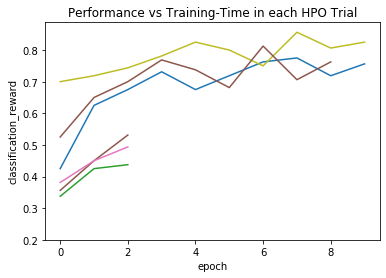

Accuracy on Validation Data: 0.825


In [6]:
num_train_epochs = 10 # How many epochs to train each network. Small value used just for quick demo, you should increase it.
num_hpo_trials = 16 # How many networks to train with different hyperparameters. Small value used just for quick demo, you should increase it.
ngpus_per_trial = 1 # How many GPUs to use per training run. Set =0 if you don't have GPU but beware of slow run-times (otherwise make sure GPU-version of MXNet is installed).

classifier = task.fit(dataset, plot_results=True,
                      search_strategy='hyperband', scheduler_options={'grace_period':1},
                      net=net, optimizer=optimizer, lr_scheduler=ag.space.Categorical('poly', 'cosine'),
                      epochs=num_train_epochs, num_trials=num_hpo_trials, ngpus_per_trial=ngpus_per_trial)

print('Accuracy on Validation Data: %.3f' % classifier.results['best_reward'])

You can see that AutoGluon early-terminated many training jobs whose performance in early epochs was significantly worse than in the same epochs of previously-completed training runs. [Hyperband](https://homes.cs.washington.edu/~jamieson/hyperband.html) is based on successive halving of randomly-sampled configurations, where we terminate the worst-performing 50% of the current training jobs every few epochs. However  this may be too aggressive; some good hyperparameter-configurations may just happen to exhibit poor performance at a certain training stage but would end up producing good performance at the end of training. To ensure such configurations have a chance of surviving, Hyperband runs successive-halving in numerous brackets where random networks in every bracket are trained for all epochs. Below we show what training-performance might look like over the course of 4 different Hyperband brackets (one per plot):   

<img src="files/images/hyperband.png" width="500" height="400">

AutoGluon actually uses an [asychronous version of Hyperband](https://blog.ml.cmu.edu/2018/12/12/massively-parallel-hyperparameter-optimization/) that is slightly more complex. 
Finally, we evaluate the resulting model from our Hyperband-search on the test data:

In [7]:
test_acc = classifier.evaluate(test_dataset)
print('Accuracy on test data: %.3f' % test_acc)


Accuracy on test data: 0.891


You can try playing with AutoGluon's various [searchers](https://autogluon.mxnet.io/api/autogluon.searcher.html) & [schedulers](https://autogluon.mxnet.io/api/autogluon.scheduler.html) to see how they affect the resulting image-classification accuracy (make sure to increase `num_train_epochs`, `num_hpo_trials` to get a more realistic picture). 
For large-scale HPO, you can also use AutoGluon to easily distribute these HPO jobs over multiple machines, as demonstrated in this [Distributed Search tutorial](https://autogluon.mxnet.io/tutorials/course/distributed.html). 

## References

[**AutoGluon Documentation** (autogluon.mxnet.io)](https://autogluon.mxnet.io/api/autogluon.task.html)

Feurer M, Hutter F. [**Hyperparameter Optimization**](https://www.automl.org/wp-content/uploads/2019/05/AutoML_Book_Chapter1.pdf). Book chapter in *AUTOML: METHODS, SYSTEMS, CHALLENGES*, 2018.

Agnihotri et al. [**Exploring Bayesian Optimization**](https://distill.pub/2020/bayesian-optimization/). *Distill*, 
2020.

Shahriari et al. [**Taking the Human Out of the Loop: A Review of Bayesian Optimization**](https://www.cs.ox.ac.uk/people/nando.defreitas/publications/BayesOptLoop.pdf). *Proceedings of the IEEE*, 2015.

Jamieson et al. [**Hyperband: A Novel Bandit-Based Approach to Hyperparameter Optimization**](https://homes.cs.washington.edu/~jamieson/hyperband.html). *Journal of Machine Learning Research*, 2018.

Li et al. [**Massively Parallel Hyperparameter Optimization**](https://arxiv.org/abs/1810.05934). In: *MLSys*, 2020.